In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from scipy.stats import zscore

In [2]:
# Load in the data
df = pd.read_csv('concrete.csv')
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


### Analyzing data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [4]:
df.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength'],
      dtype='object')

In [5]:
df.shape

(1030, 9)

In [6]:
# to remove duplicate rows
df = df.copy()
df.duplicated().sum()
duplicates = df.duplicated()
df[duplicates]
df.drop_duplicates(inplace=True)

In [7]:
df_stats = df.describe().T
df_stats

,count,mean,std,min,25%,50%,75%,max
cement,1005.0,278.631343,104.344261,102.00,190.70,265.0,349.00,540.0
slag,1005.0,72.043483,86.170807,0.00,0.00,20.0,142.50,359.4
ash,1005.0,55.536318,64.207969,0.00,0.00,0.0,118.30,200.1
water,1005.0,182.075323,21.339334,121.80,166.60,185.7,192.90,247.0
superplastic,1005.0,6.033234,5.919967,0.00,0.00,6.1,10.00,32.2
coarseagg,1005.0,974.376816,77.579667,801.00,932.00,968.0,1031.00,1145.0
fineagg,1005.0,772.688259,80.340435,594.00,724.30,780.0,822.20,992.6
age,1005.0,45.856716,63.734692,1.00,7.00,28.0,56.00,365.0
strength,1005.0,35.250378,16.284815,2.33,23.52,33.8,44.87,82.6


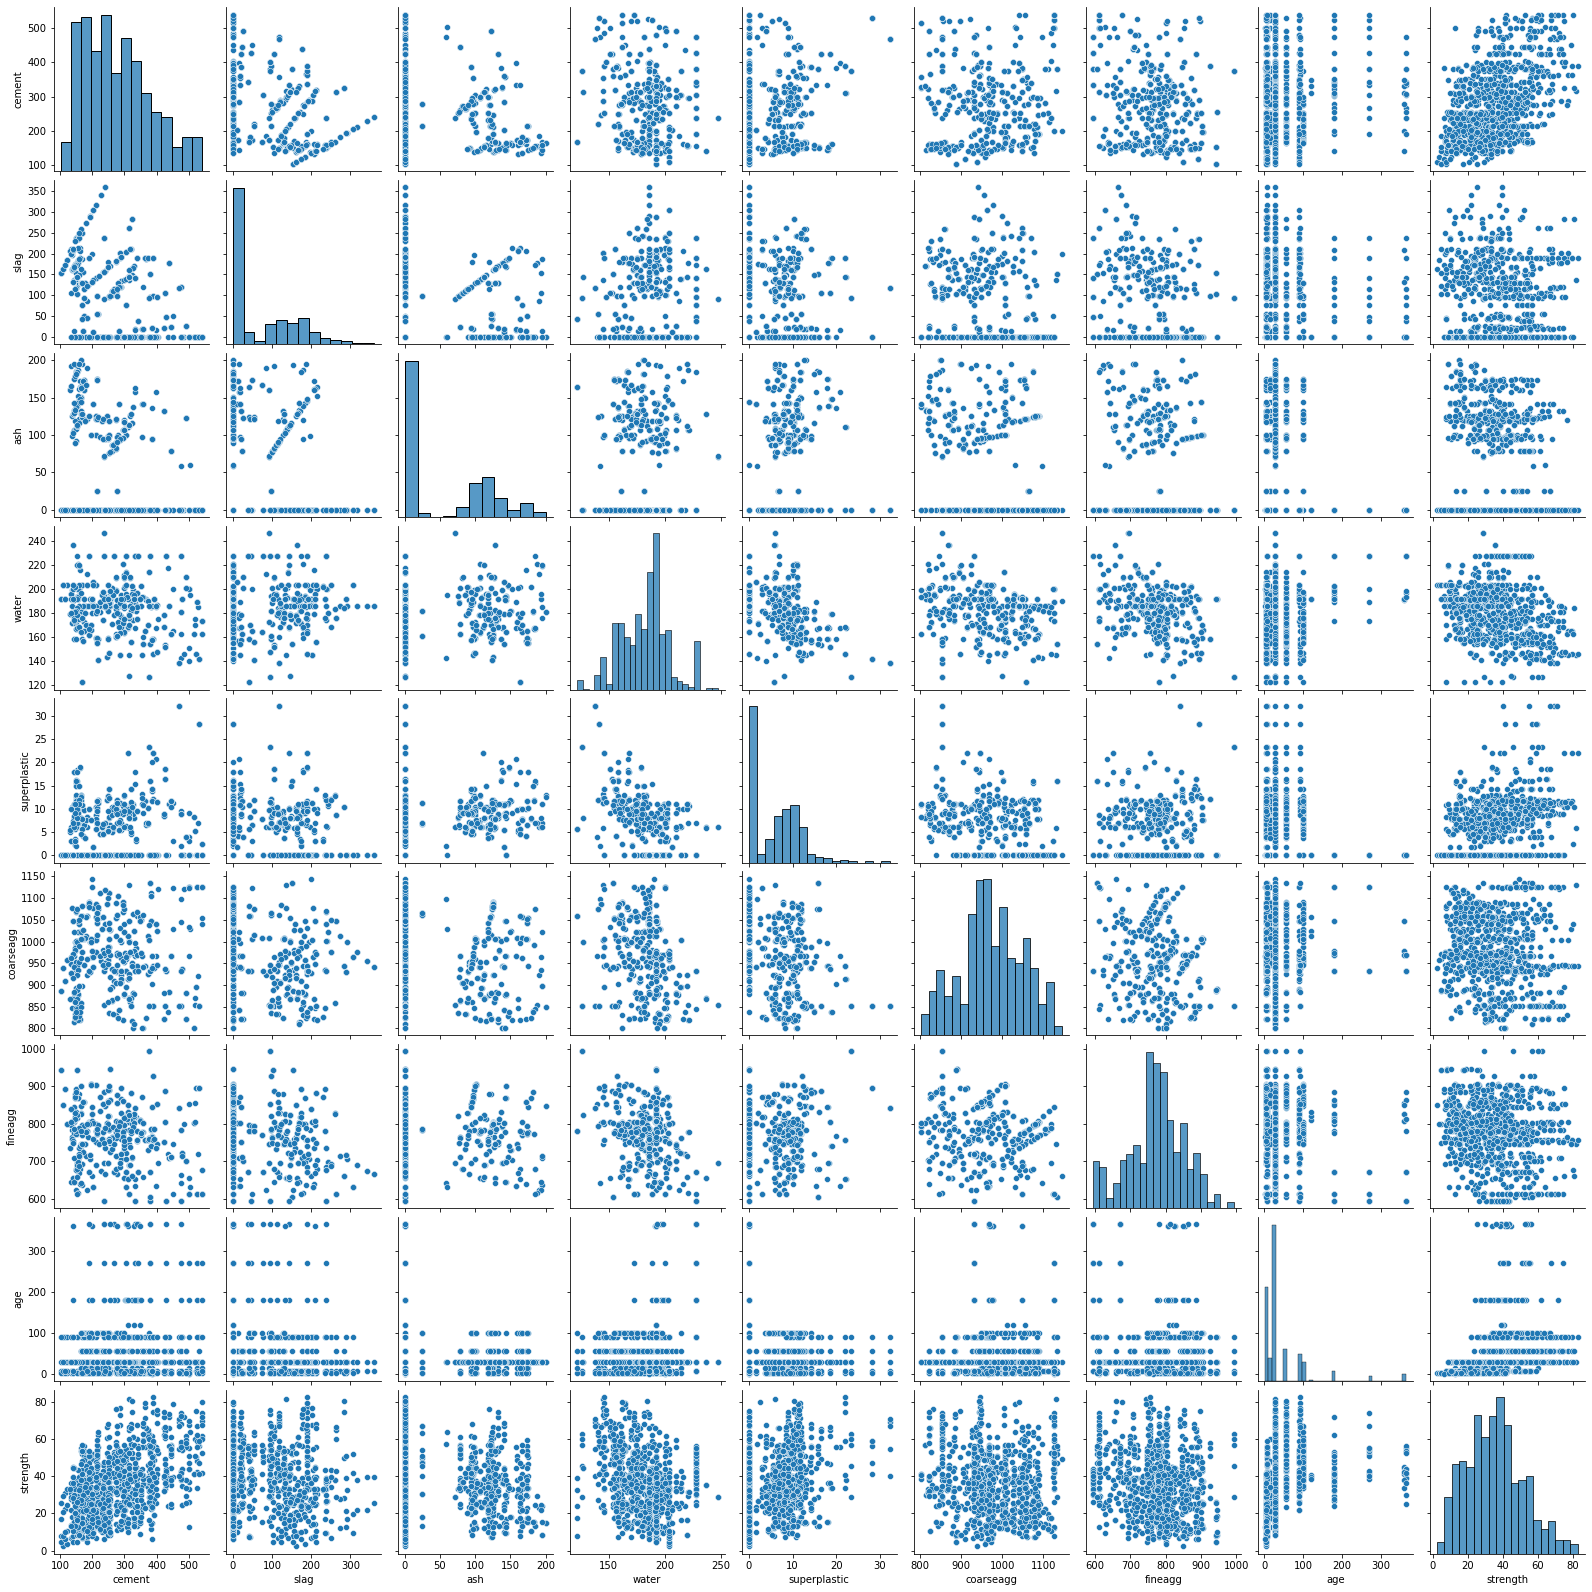

In [8]:
sns.pairplot(df)

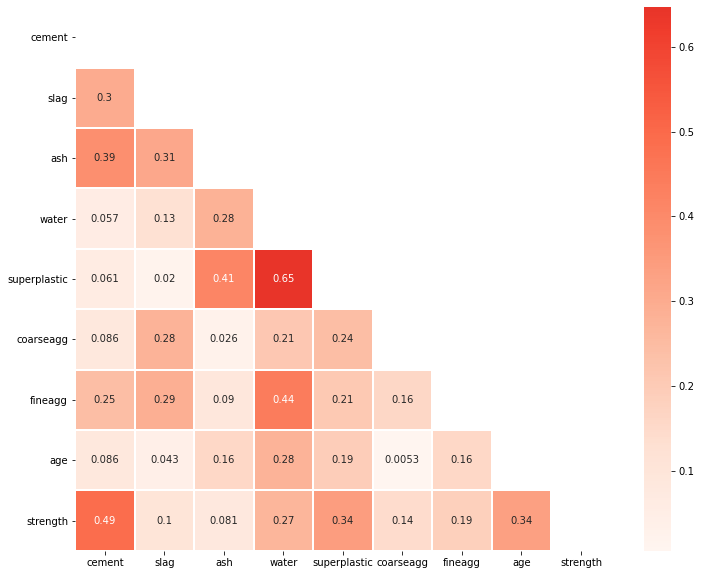

In [9]:
corr = abs(df.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (12,10))
sns.heatmap(lower_triangle, center = 0.5, cmap = plt.cm.Reds, annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= True, linewidths= 1, mask = mask)   # Da Heatmap
plt.show()

In [10]:
df = df.copy()

<AxesSubplot:>

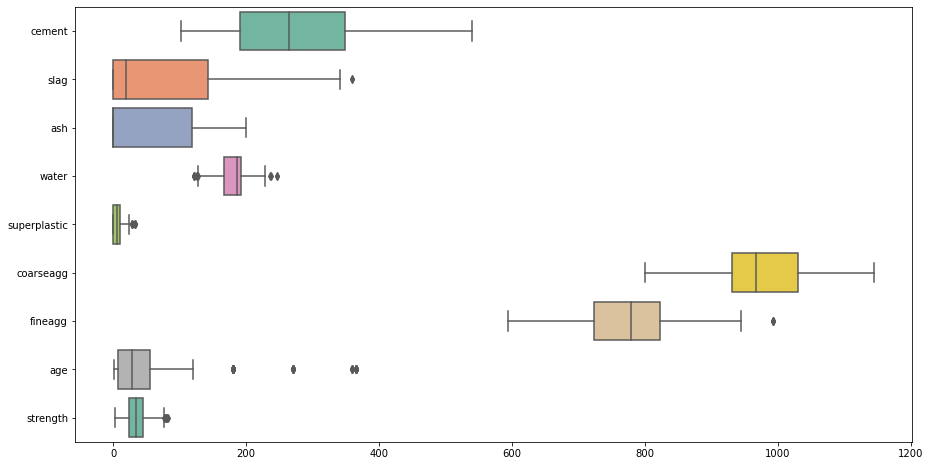

In [11]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df, orient="h", palette="Set2", dodge=False)

### Removing Outliers

In [12]:
# to determine the outliers
df_outliers = pd.DataFrame(df.loc[:,])

# Calculate IQR
Q1 = df_outliers.quantile(0.25)
Q3 = df_outliers.quantile(0.75)
IQR = Q3 - Q1

print(IQR)

cement          158.30
slag            142.50
ash             118.30
water            26.30
superplastic     10.00
coarseagg        99.00
fineagg          97.90
age              49.00
strength         21.35
dtype: float64


In [13]:
# to use IQR score to filter out the outliers by keeping only valid values

# to REPLACE every outlier on the upper side by the upper whisker 
for i, j in zip(np.where(df_outliers > Q3 + 1.5 * IQR)[0], np.where(df_outliers > Q3 + 1.5 * IQR)[1]):
    
    whisker_upper  = Q3 + 1.5 * IQR
    df_outliers.iloc[i,j] = whisker_upper[j]
    
# to REPLACE every outlier on the lower side by the lower whisker 
for i, j in zip(np.where(df_outliers < Q1 - 1.5 * IQR)[0], np.where(df_outliers < Q1 - 1.5 * IQR)[1]): 
    
    whisker_lower  = Q1 - 1.5 * IQR
    df_outliers.iloc[i,j] = whisker_lower[j] #indexing
    
#we have to use the zip function to make it compatible with the for loop
#zero in the data does not mean blank
# the code can always remain the same. This can be used as a template

<AxesSubplot:>

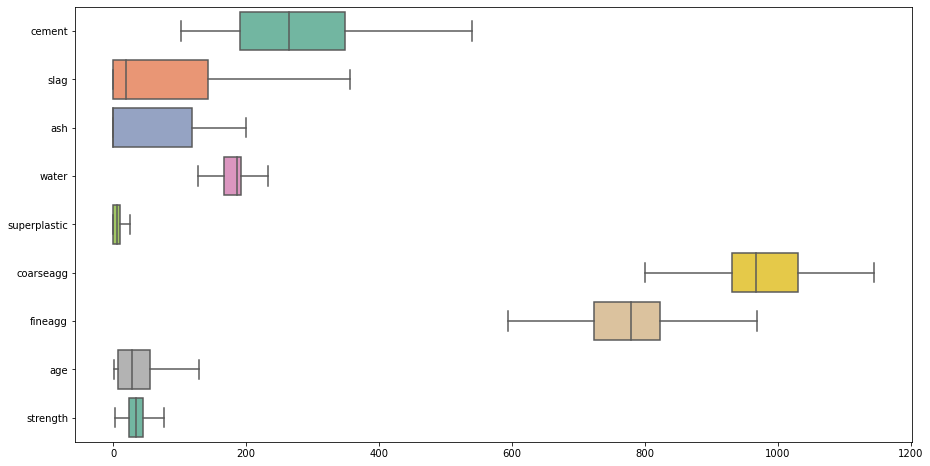

In [14]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df, orient="h", palette="Set2", dodge=False)

In [15]:
#to identify any missing values
df.isnull().sum().sort_values(ascending=False)

strength        0
age             0
fineagg         0
coarseagg       0
superplastic    0
water           0
ash             0
slag            0
cement          0
dtype: int64

In [16]:
df.shape

(1005, 9)

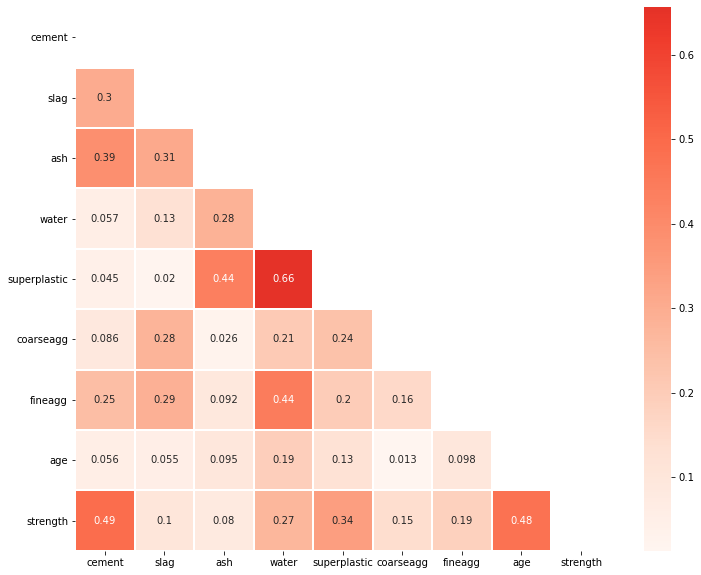

In [17]:
corr = abs(df.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (12,10))
sns.heatmap(lower_triangle, center = 0.5, cmap = plt.cm.Reds, annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= True, linewidths= 1, mask = mask)   # Da Heatmap
plt.show()

In [18]:
from sklearn.cluster import KMeans
cluster_range = range( 2, 6 )   # expect 3 to four clusters from the pair panel visual inspection hence restricting from 2 to 6
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 5)
  clusters.fit(df)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:15]
cluster = KMeans( n_clusters = 3, random_state = 2354 )
cluster.fit(df)

KMeans(n_clusters=3, random_state=2354)

### Creating the Dependent and Independent Variables

In [19]:
#Standardizing the data using zscore
df = df.apply(zscore)
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,-1.316792,1.625450,-0.865375,1.013480,-1.045420,-0.033232,-0.300903,-0.281105,-0.329155
1,-1.052152,-0.346513,1.071486,-1.123827,0.842159,1.372475,0.295376,-0.671679,-0.722686
2,-0.274530,-0.836600,0.625836,0.252182,-0.084153,-0.225388,1.107915,-0.281105,-0.370482
3,-0.121115,0.487332,-0.865375,2.171975,-1.045420,-0.546508,-1.282201,-0.281105,0.655290
4,-1.187348,1.293305,-0.865375,0.531167,0.545040,0.941736,-0.948435,-0.281105,-1.044666


In [20]:
# To create the matrix of dependent variable, Y
Y = df['strength']
# To create the matrix of independent variable, X
X = df[['age', 'cement', 'superplastic', 'water']]

In [21]:
X

,age,cement,superplastic,water
0,-0.281105,-1.316792,-1.045420,1.013480
1,-0.671679,-1.052152,0.842159,-1.123827
2,-0.281105,-0.274530,-0.084153,0.252182
3,-0.281105,-0.121115,-1.045420,2.171975
4,-0.281105,-1.187348,0.545040,0.531167
...,...,...,...,...
1025,-0.281105,-1.377199,0.702338,-0.097731
1026,-0.978558,2.422696,3.323976,-1.904038
1027,-0.281105,-0.021395,0.510085,-0.116645
1028,2.550555,0.607606,-1.045420,2.171975


In [22]:
#### To split the whole dataset into training dataset and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0) #train_size=0.8, you can either still put this or not since test_size is already defined. By default, remaining is for training

In [23]:
X_train.shape

(804, 4)

In [24]:
X_test.shape

(201, 4)

In [25]:
Y_train.shape

(804,)

In [26]:
Y_test.shape

(201,)

In [27]:
regr = MLPRegressor(max_iter=1000)

In [28]:
parameters = {
            'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'activation': ['relu','tanh'],
            'alpha': [0.0001, 0.001, 0.05],
            'learning_rate': ['constant','adaptive'],
            'solver': ['sgd', 'adam']}



In [29]:
# To apply K-fold cross-validation for the simple linear regression model
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=10, random_state=1, shuffle=True)
grid = GridSearchCV(estimator=regr, param_grid=parameters, scoring='neg_mean_absolute_error', cv=k_fold, verbose=0)

In [30]:
grid.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=MLPRegressor(max_iter=1000),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='neg_mean_absolute_error')

In [31]:
# To Identify the Best Accuracy and Best Features

best_accuracy = grid.best_score_
best_parameters = grid.best_params_

print("BEST ACCURACY SCORE:")
print(best_accuracy)
print('')

print("BEST PARAMETERS:")
print(best_parameters)

BEST ACCURACY SCORE:
-0.35013523623717513

BEST PARAMETERS:
{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [38]:
regr = MLPRegressor(max_iter=1000, activation='relu', hidden_layer_sizes=(50,100,50), learning_rate='constant', solver='adam').fit(X_train, Y_train)

In [39]:
regr.score(X_test, Y_test)

0.7793053219345972

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
# For the Mean Absolute Error as scoring for for cross-validation 
MAE = (cross_val_score(estimator=regr, X=X_train, y=Y_train, cv=k_fold, scoring='neg_mean_absolute_error'))*-1

MAE_average = MAE.mean()
MAE_variance = MAE.std()

print('Mean Absolute Error of K-FOLDS:')
print (MAE)
print(' ')
print('Average Mean Absolute Error of K-FOLDS:')
print(MAE_average)
print(' ')
print('Mean Absolute Error Variance of K-FOLDS:')
print(MAE_variance)
print(' ')

Mean Absolute Error of K-FOLDS:
[0.35496358 0.29891565 0.34265086 0.37909024 0.36156185 0.27732714
 0.3876809  0.34916122 0.3453552  0.36522681]
 
Average Mean Absolute Error of K-FOLDS:
0.346193346575114
 
Mean Absolute Error Variance of K-FOLDS:
0.03237066293119553
 
